In [6]:
import sys

sys.path.append('/Users/ingvild/Documents/Prosjektoppgave/GitHub_project')
from Prosjektoppgave import nifty_dim

                Number of images
(512, 512, 20)                 4
(512, 512, 38)                78
(512, 512, 35)                 4
(512, 512, 29)                 2
(256, 256, 21)                 2
(256, 256, 22)                 4
(256, 256, 24)                 2
(256, 256, 20)                 4
(512, 512, 40)                 2
(512, 512, 36)                 2
(512, 512, 37)                 2
(512, 512, 32)                 2
(512, 512, 39)                 2
(640, 640, 36)                64
(384, 384, 36)                 2
(640, 640, 16)                 2
(512, 512, 18)                 2


In [32]:

"""
Functions to analyse results
Note:
when you load a mask.nii file (both ground truth and predicted mask)
use
sitk.ReadImage(path_to_file)>0
in order to get a binary image!
"""
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
import get_data as gd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def calculate_dice(mask_a, mask_b):
    """
    Calculate DICE score for two binary masks (=sitk images)
    """
    npa1 = sitk.GetArrayFromImage(mask_a)
    npa2 = sitk.GetArrayFromImage(mask_b)

    dice = 2*np.count_nonzero(npa1 & npa2) / (np.count_nonzero(npa1) + np.count_nonzero(npa2))
    return dice

def calculate_msd(mask_a, mask_b):
    """
    Calulate mean average surface distance between mask a and b
    """
    mask_b.CopyInformation(mask_a)
    # masks need to occupy exactly the same space and no spacial information is
    # saved in the matlab script

    contour_list =[sitk.LabelContour(m) for m in [mask_a, mask_b]]

    n_voxel = []
    mean_val = []

    for a, b in [(0,1), (1,0)]:
        distance_map = sitk.Abs(sitk.SignedMaurerDistanceMap(contour_list[a],
                                                         squaredDistance=False,
                                                         useImageSpacing=True))
        stat_intensity_filter = sitk.LabelIntensityStatisticsImageFilter()
        stat_intensity_filter.Execute(contour_list[b], distance_map)
        n_voxel.append(stat_intensity_filter.GetNumberOfPixels(1))
        mean_val.append(stat_intensity_filter.GetMean(1))

    # combine the two values to get 'symmetric' values
    MSD=(n_voxel[0]*mean_val[0]+n_voxel[1]*mean_val[1])/(n_voxel[0]+n_voxel[1])

    return MSD

def mean_columns(dataframe):
    dict = {}
    for column in dataframe:
        dict[column] = [dataframe[column].mean()]
    return dict

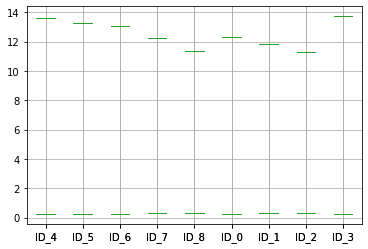

In [3]:
result_folder = '/Volumes/Untitled/Results/'

resultPaths = {}


for experiment in os.listdir(result_folder):
    experimentPath = os.path.join(result_folder, experiment)
    if os.path.isdir(experimentPath):
        for patient in os.listdir(experimentPath):
            patientResultPath = os.path.join(experimentPath, patient)
            if experiment in resultPaths:
                resultPaths[experiment].append(patientResultPath)
            else:
                resultPaths[experiment] = [patientResultPath]

patientsPaths, patientsNames, patientsPaths_image, patientPaths_groundTruth = gd.get_paths('/Volumes/Untitled/LARC_T2_preprocessed', image_prefix='image', mask_suffix='label.nii')
patientPaths_groundTruth.insert(0, patientPaths_groundTruth.pop(len(patientPaths_groundTruth) - 1))

dice = {}
msd = {}

for key in resultPaths:
    for i in range(len(patientPaths_groundTruth)):
        mask_pred = sitk.ReadImage(resultPaths[key][i]) > 0
        mask_truth = sitk.ReadImage(patientPaths_groundTruth[i]) > 0
        dice_score = calculate_dice(mask_pred, mask_truth)
        msd_score = calculate_msd(mask_pred, mask_truth)
        if key in dice:
            dice[key].append(dice_score)
            msd[key].append(msd_score)
        else:
            dice[key] = [dice_score]
            msd[key] = [msd_score]


In [22]:
df_dice = pd.DataFrame(dice)
df_msd = pd.DataFrame(msd)
mean_dice = mean_columns(df_dice)
mean_msd = mean_columns(df_msd)

df_dice_mean = pd.DataFrame(mean_dice)
df_msd_mean = pd.DataFrame(mean_msd)

In [23]:
print(df_dice.head())
print(df_msd.head())

       ID_4      ID_5      ID_6      ID_7      ID_8      ID_0      ID_1  \
0  0.319559  0.358313  0.350359  0.390549  0.471907  0.390026  0.413026   
1  0.248758  0.284693  0.194038  0.249231  0.308991  0.214102  0.260524   
2  0.200916  0.237036  0.273352  0.284753  0.313207  0.318708  0.306084   
3  0.334057  0.395977  0.280115  0.355069  0.432374  0.305186  0.364915   
4  0.222076  0.232537  0.162463  0.140228  0.151623  0.128193  0.122774   

       ID_2      ID_3  
0  0.480214  0.369622  
1  0.317404  0.193731  
2  0.313040  0.313099  
3  0.442823  0.290284  
4  0.149149  0.199516  
        ID_4       ID_5       ID_6       ID_7       ID_8       ID_0  \
0  13.699157  12.854159  13.626543  13.145057  11.706459  12.529648   
1  11.990043  12.025323  13.652594  11.697545   9.724169  12.772085   
2  13.646368  13.705222  11.938986  13.092841  14.394152  11.066091   
3  10.305539   9.112421  14.130362  10.735912   9.598054  12.930275   
4  13.204427  12.480972  13.279316  12.536421  11.

In [24]:
cols_dice = list(df_dice.columns.values)
cols_msd = list(df_msd.columns.values)

cols_dice = cols_dice[5:] + cols_dice[:5]
cols_msd = cols_msd[5:] + cols_msd[:5]

df_dice = df_dice[cols_dice]
df_msd = df_msd[cols_msd]
print(df_dice.head())
print(df_msd.head())

       ID_0      ID_1      ID_2      ID_3      ID_4      ID_5      ID_6  \
0  0.390026  0.413026  0.480214  0.369622  0.319559  0.358313  0.350359   
1  0.214102  0.260524  0.317404  0.193731  0.248758  0.284693  0.194038   
2  0.318708  0.306084  0.313040  0.313099  0.200916  0.237036  0.273352   
3  0.305186  0.364915  0.442823  0.290284  0.334057  0.395977  0.280115   
4  0.128193  0.122774  0.149149  0.199516  0.222076  0.232537  0.162463   

       ID_7      ID_8  
0  0.390549  0.471907  
1  0.249231  0.308991  
2  0.284753  0.313207  
3  0.355069  0.432374  
4  0.140228  0.151623  
        ID_0       ID_1       ID_2       ID_3       ID_4       ID_5  \
0  12.529648  12.623212  11.563876  14.582151  13.699157  12.854159   
1  12.772085  11.316548   9.503031  12.877036  11.990043  12.025323   
2  11.066091  12.362245  14.235353  13.717723  13.646368  13.705222   
3  12.930275  10.335087   9.011011  15.082647  10.305539   9.112421   
4  12.855998  12.396687  11.558812  13.757966  13.

Text(0, 0.5, 'DICE')

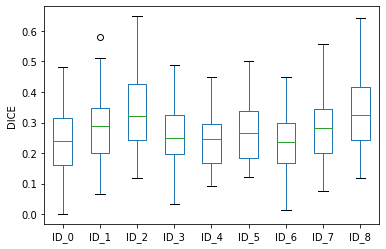

In [34]:
plt.figure()
boxplot_dicedist = df_dice.boxplot(grid=False)
plt.ylabel('DICE')

Text(0, 0.5, 'MSD')

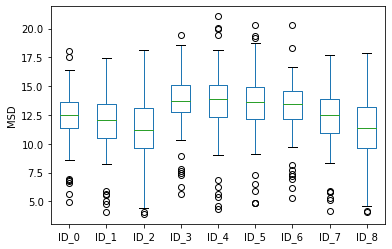

In [36]:
plt.figure()
boxplot_msddist = df_msd.boxplot(grid=False)
plt.ylabel('MSD')